# Assignment 2
## Steve Cheney
### RBIF110



## Problem 1

In [1]:
%pip install pandas
%pip install rdkit
%pip install numpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached rdkit-2024.9.4-cp311-cp311-win_amd64.whl.metadata (4.1 kB)
Using cached rdkit-2024.9.4-cp311-cp311-win_amd64.whl (22.4 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import AllChem
from rdkit.Chem import SaltRemover
import numpy as np
from rdkit.DataStructs import FingerprintSimilarity
from rdkit import RDLogger
from rdkit.Chem import PandasTools
from rdkit import DataStructs


In [14]:
# Read in the data files

# Assuming you conver the xls to a csv

lc50_data = "FishLC50.csv"
try:
    lc50_df = pd.read_csv(lc50_data, sep=",", encoding="utf-8")
except UnicodeDecodeError:
    lc50_df = pd.read_csv(lc50_data, sep=",", encoding="latin-1")



bbb_data = "BBB_Data.txt"
try:
    bbb_df = pd.read_csv(bbb_data, sep="\t", encoding="utf-8")
except UnicodeDecodeError:
    bbb_df = pd.read_csv(bbb_data, sep="\t", encoding="latin-1")

#lc50_df.head()
#bbb_df.head()


,STRUCTURE_SMILES,LC50_mmol
0,OCCN(CCO)CCO,79.100
1,CN(C)N,0.131
2,NCCCN,16.100
3,OCCNCCO,44.800
4,CS(=O)C,435.000


In [5]:
print(data.columns)

small_molecule_count = (data['Type'] == 'Small molecule').sum()

print(f"1b. Number of Small molecules: {small_molecule_count} ({(small_molecule_count/len(data) * 100):.3f}%)")

Index(['ChEMBL ID', 'Name', 'Synonyms', 'Type', 'Max Phase',
       'Molecular Weight', 'Targets', 'Bioactivities', 'AlogP', 'PSA', 'HBA',
       'HBD', '#RO5 Violations', '#Rotatable Bonds', 'Passes Ro3',
       'QED Weighted', 'ACD ApKa', 'ACD BpKa', 'ACD LogP', 'ACD LogD',
       'Aromatic Rings', 'Structure Type', 'Inorganic Flag', 'Heavy Atoms',
       'HBA Lipinski', 'HBD Lipinski', '#RO5 Violations (Lipinski)',
       'Molecular Weight (Monoisotopic)', 'Molecular Species',
       'Molecular Formula', 'Smiles'],
      dtype='object')
1b. Number of Small molecules: 1849655 (98.427%)


In [6]:
# Count the number of duplicate ChEMBL IDs
duplicate_chembl_count = data['ChEMBL ID'].duplicated().dropna().sum()
print(f"Number of duplicate ChEMBL IDs: {duplicate_chembl_count}")
# Count the number of duplicate Names
duplicate_name_count = data['Name'].duplicated().dropna().sum()
print(f"Number of duplicate Names: {duplicate_name_count}")
# Count the number of duplicate SMILES entries (ignoring missing values)
duplicate_smiles_count = data['Smiles'].duplicated().dropna().sum()
print(f"Number of duplicate SMILES: {duplicate_smiles_count}")

Number of duplicate ChEMBL IDs: 0
Number of duplicate Names: 1836031
Number of duplicate SMILES: 8895


In [7]:
search_criteria = {
    'ChEMBL ID': 'CHEMBL14762',
    'Name': 'SELICICLIB',
    'Molecular Formula': 'C19H26N6O',
    'Smiles': 'CC[C@H](CO)Nc1nc(NCc2ccccc2)c2ncn(C(C)C)c2n1'
}

matching_entry = data[
    (data['ChEMBL ID'] == search_criteria['ChEMBL ID'])
    & (data['Name'].str.lower() == search_criteria['Name'].lower())
    # & (data['Molecular Formula'] == search_criteria['Molecular Formula'])
    # & (data['Smiles'] == search_criteria['Smiles'])
]

if not matching_entry.empty:
    print("Matching entry found:")
    print(matching_entry)
else:
    print("No matching entry found.")

Matching entry found:
          ChEMBL ID        Name                     Synonyms            Type  \
788837  CHEMBL14762  SELICICLIB  AL-39256|CYC-202|SELICICLIB  Small molecule   

        Max Phase  Molecular Weight  Targets  Bioactivities  AlogP    PSA  \
788837          2            354.46      894         2149.0    3.2  87.89   

        ...  Structure Type  Inorganic Flag  Heavy Atoms  HBA Lipinski  \
788837  ...             MOL               0         26.0           7.0   

       HBD Lipinski  #RO5 Violations (Lipinski)  \
788837          3.0                         0.0   

        Molecular Weight (Monoisotopic)  Molecular Species  Molecular Formula  \
788837                         354.2168            NEUTRAL          C19H26N6O   

                                              Smiles  
788837  CC[C@H](CO)Nc1nc(NCc2ccccc2)c3ncn(C(C)C)c3n1  

[1 rows x 31 columns]


In [11]:
def standardize_smiles(smiles):
    '''This function takes a non-canonical SMILES and
    returns the canonical version

    Args:
        -smiles: str, non-canonical SMILES of a molecule

    Out:
        - canonical_smiles: str, canonical SMILES of the molecule
    '''

    # Handle any issues with missing values
    if not isinstance(smiles, str) or smiles.strip() == "" or pd.isna(smiles):
        return None
    
    mol = Chem.MolFromSmiles(smiles) #create a mol object from input smiles


    largest_Fragment = rdMolStandardize.LargestFragmentChooser()    
    standardized_smiles = largest_Fragment.choose(mol) #standardize the input string by taking the largest fragment

    canonical_smiles = Chem.MolToSmiles(standardized_smiles) #convert the previous mol object to SMILES using Chem.MolToSmiles()

    ####END
    return canonical_smiles

def get_standard_mol(smiles):
    '''This function takes a non-canonical SMILES converts to the canonical version, then returns the mol object

    Args:
        -smiles: str, non-canonical SMILES of a molecule

    Out:
        - obj: mol object of the converted canonical molecule
    '''
    
    if smiles is None:
        return None

    try:
        mol_obj = Chem.MolFromSmiles(standardize_smiles(smiles))
        return mol_obj if mol_obj else None
    except:
        return None

def get_fingerprint(mol, radius=2, bits=1024):
    if mol is None:
        return None  # Prevents passing None to the RDKit function
    
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=bits)

# Suppress RDKit warnings and informational messages
RDLogger.DisableLog('rdApp.*')  # Disables all RDKit logging messages

def clean_df_and_create_mol_col(df, smilesCol, molCol, subset_len=-1, remove_na=True):

    if subset_len == -1:
        data_subset = df.copy()
    else:
        data_subset = df.iloc[:subset_len].copy()

    # Clean data
    data_subset = data_subset[data_subset[smilesCol].notna()]  # Remove NaN values
    data_subset[smilesCol] = data_subset[smilesCol].astype(str)  # Ensure all values are strings

    PandasTools.AddMoleculeColumnToFrame(data_subset, smilesCol=smilesCol, molCol=molCol)

    return data_subset


# Clean the data to ignore any NaN smiles values and subset data if needed
data_subset = clean_df_and_create_mol_col(data, 'Smiles', 'rdkit_mol')
# Get the standardized mol object from the standard SMILES
data_subset['standardized_mol'] = data_subset['Smiles'].apply(get_standard_mol)
# Get the fingerprint
data_subset['fingerprint'] = data_subset['standardized_mol'].apply(get_fingerprint)
data_subset.head()

,ChEMBL ID,Name,Synonyms,Type,Max Phase,Molecular Weight,Targets,Bioactivities,AlogP,PSA,...,HBA Lipinski,HBD Lipinski,#RO5 Violations (Lipinski),Molecular Weight (Monoisotopic),Molecular Species,Molecular Formula,Smiles,rdkit_mol,standardized_mol,fingerprint
2,CHEMBL4116853,NaN,NaN,Small molecule,0,392.91,0,NaN,3.20,87.46,...,6.0,4.0,0.0,392.1074,NEUTRAL,C18H21ClN4O2S,CCN1CCc2c(C1)sc(NC(=O)NCc3cccc(Cl)c3)c2C(=O)N,<rdkit.Chem.rdchem.Mol object at 0x000002230A5...,<rdkit.Chem.rdchem.Mol object at 0x000002230A5...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,CHEMBL4117318,NaN,NaN,Small molecule,0,498.45,0,NaN,6.35,44.81,...,5.0,1.0,1.0,497.1637,NEUTRAL,C27H29Cl2N3O2,Clc1cccc(N2CCN(CCCCNC(=O)Oc3ccc(cc3)c4ccccc4)C...,<rdkit.Chem.rdchem.Mol object at 0x000002230A5...,<rdkit.Chem.rdchem.Mol object at 0x0000022DD7B...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,CHEMBL4116337,NaN,NaN,Small molecule,0,524.45,0,NaN,5.27,116.95,...,8.0,4.0,2.0,523.0790,BASE,C23H22BrN7OS,NC(=N)N1CCC[C@H]1Cc2onc(n2)c3ccc(Nc4nc(cs4)c5c...,<rdkit.Chem.rdchem.Mol object at 0x00000223428...,<rdkit.Chem.rdchem.Mol object at 0x0000022DD7B...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,CHEMBL2105851,BISDEQUALINIUM DIACETATE,BISDEQUALINIUM DIACETATE,Small molecule,0,713.02,0,NaN,9.96,31.82,...,4.0,2.0,2.0,594.4651,NEUTRAL,C44H64N4O4,CC(=O)[O-].CC(=O)[O-].Cc1cc2NCCCCCCCCCCNc3cc(C...,<rdkit.Chem.rdchem.Mol object at 0x00000223428...,<rdkit.Chem.rdchem.Mol object at 0x0000022DD7B...,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,CHEMBL3991223,NaN,NaN,Small molecule,0,447.90,0,NaN,3.09,85.27,...,8.0,1.0,0.0,447.1473,NEUTRAL,C21H23ClFN5O3,CC(N1CC(C1)Oc2c(F)cccc2Cl)C3=Nc4c(cnn4C5CCOCC5...,<rdkit.Chem.rdchem.Mol object at 0x00000223428...,<rdkit.Chem.rdchem.Mol object at 0x0000022DD7B...,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ..."


In [22]:
# Set up seliciclib for comparison
#seliciclib_smiles = 'CC[C@H](CO)Nc1nc(NCc2ccccc2)c3ncn(C(C)C)c3n1'
#seliciclib = get_standard_mol(seliciclib_smiles)

seliciclib_fp = data_subset.loc[data_subset['ChEMBL ID'] == "CHEMBL14762", 'fingerprint'].iloc[0]
print(seliciclib_fp)

# Calculate the similarity of each fingerprint to seliciclib_fp and store results in a new column
data_subset['similarity'] = data_subset['fingerprint'].apply(
    lambda fp: DataStructs.FingerprintSimilarity(seliciclib_fp, fp) if fp is not None else 0
)

# Sort the DataFrame by similarity and get the top 5 most similar compounds
top_5_similar = data_subset[data_subset['ChEMBL ID'] != "CHEMBL14762"].sort_values(by='similarity', ascending=False).head(5)

# Return the 'Name' column of the top 5 results
top_5_ids = top_5_similar['ChEMBL ID'].tolist()
top_5_names = top_5_similar['Name'].tolist()

print("Top 5 most similar compounds:")
print(top_5_ids)
print(top_5_names)

Top 5 most similar compounds:
['CHEMBL133342', 'CHEMBL52387', 'CHEMBL461557', 'CHEMBL131697', 'CHEMBL2111870']
['(S)-ROSCOVITINE', '(RS)-ROSCOVITINE', nan, nan, nan]


In [23]:
bit_list = [64, 128, 256, 512, 1024]
new_fp_data = data_subset.copy()
for bit in bit_list:
    new_fp_data[f'fingerprint_{bit}'] = new_fp_data['standardized_mol'].apply(lambda mol: get_fingerprint(mol, radius=2, bits=bit))


In [27]:
def rank_fingerprints(chemblid):
    fp_bits = ['fingerprint_64', 'fingerprint_128', 'fingerprint_256', 'fingerprint_512', 'fingerprint_1024', 'fingerprint']

    for fp_bit in fp_bits:

        fp_to_compare = new_fp_data.loc[new_fp_data['ChEMBL ID'] == chemblid, fp_bit].iloc[0]

        # Calculate the similarity of each fingerprint to seliciclib_fp and store results in a new column
        new_fp_data['similarity'] = new_fp_data[fp_bit].apply(
            lambda fp: DataStructs.FingerprintSimilarity(fp_to_compare, fp) if fp is not None else 0
        )

        # Sort the DataFrame by similarity and get the top 5 most similar compounds
        top_3_similar = new_fp_data[new_fp_data['ChEMBL ID'] != chemblid].sort_values(by='similarity', ascending=False).head(3)

        # Return the 'Name' column of the top 3 results
        top_3_ids = top_3_similar['ChEMBL ID'].tolist()
        top_3_names = top_3_similar['Name'].tolist()

        print(f"Top 3 most similar compounds ({fp_bit}):")
        #print(top_3_ids)
        #print(top_3_names)
        print(f"({top_3_ids[0]}, {top_3_names[0]}); ({top_3_ids[1]}, {top_3_names[1]}); ({top_3_ids[2]}, {top_3_names[2]})")

rank_fingerprints("CHEMBL14762")

Top 3 most similar compounds (fingerprint_64):
(CHEMBL133342, (S)-ROSCOVITINE); (CHEMBL52387, (RS)-ROSCOVITINE); (CHEMBL461557, nan)
Top 3 most similar compounds (fingerprint_128):
(CHEMBL52387, (RS)-ROSCOVITINE); (CHEMBL133342, (S)-ROSCOVITINE); (CHEMBL461557, nan)
Top 3 most similar compounds (fingerprint_256):
(CHEMBL133342, (S)-ROSCOVITINE); (CHEMBL52387, (RS)-ROSCOVITINE); (CHEMBL461557, nan)
Top 3 most similar compounds (fingerprint_512):
(CHEMBL133342, (S)-ROSCOVITINE); (CHEMBL52387, (RS)-ROSCOVITINE); (CHEMBL461557, nan)
Top 3 most similar compounds (fingerprint_1024):
(CHEMBL133342, (S)-ROSCOVITINE); (CHEMBL52387, (RS)-ROSCOVITINE); (CHEMBL461557, nan)
Top 3 most similar compounds (fingerprint):
(CHEMBL133342, (S)-ROSCOVITINE); (CHEMBL52387, (RS)-ROSCOVITINE); (CHEMBL461557, nan)


In [34]:
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator

# Define the descriptors you want to calculate
descriptors = [
    'TPSA',
    'MolLogP',
    'NumHAcceptors',
    'NumHDonors',
    'RingCount',
    'NumAromaticHeterocycles'
]

calculator = MolecularDescriptorCalculator(descriptors)

# Filter the DataFrame for the specified ChEMBL IDs
selected_chembl_ids = ['CHEMBL133342', 'CHEMBL52387', 'CHEMBL461557']
selected_mols = data_subset[(data_subset['ChEMBL ID'].isin(selected_chembl_ids)) & (data_subset['standardized_mol'].notna())]

# Calculate descriptors only for the selected valid molecules
properties = selected_mols['standardized_mol'].apply(lambda mol: calculator.CalcDescriptors(mol))

df_properties = pd.DataFrame(properties.tolist(), columns=descriptors, index=selected_mols['ChEMBL ID'].values)

df_properties

,TPSA,MolLogP,NumHAcceptors,NumHDonors,RingCount,NumAromaticHeterocycles
CHEMBL52387,87.89,3.2021,7,3,3,2
CHEMBL133342,87.89,3.2021,7,3,3,2
CHEMBL461557,87.89,4.8691,7,3,4,2


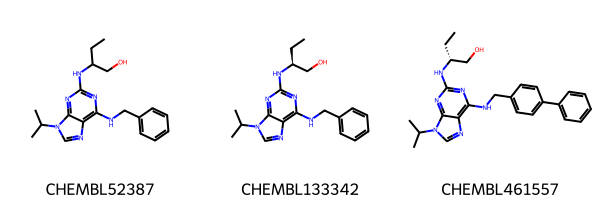

In [35]:
CHEMBL52387 = data_subset.loc[data_subset['ChEMBL ID'] == 'CHEMBL52387', 'standardized_mol'].iloc[0]
CHEMBL133342 = data_subset.loc[data_subset['ChEMBL ID'] == 'CHEMBL133342', 'standardized_mol'].iloc[0]
CHEMBL461557 = data_subset.loc[data_subset['ChEMBL ID'] == 'CHEMBL461557', 'standardized_mol'].iloc[0]

mols = [CHEMBL52387, CHEMBL133342, CHEMBL461557]
names = ['CHEMBL52387', 'CHEMBL133342', 'CHEMBL461557']

grid = Draw.MolsToGridImage(mols , legends=names)

grid